# Model 2

In [152]:
%matplotlib inline

#Importations

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from typing import Tuple
from scipy import stats
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_curve,confusion_matrix,f1_score
from sklearn.feature_selection import SelectKBest, f_classif,RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

#Variables
random_state = 42
seed = 27
test_size = 0.33
reg_lambda = 2 #XG Boost's L2 regularization term on weights, increasing it makes the model more conservative.default=1
num_of_classes = 5

In [147]:
#Read data
data = pd.read_csv("../data/first_time_loans_mid-March2018.csv")
data.head().iloc[0:1]

,user_id,payment_status,disbursment_day_of_month,disbursment_day_of_week,disbursment_hour_of_day,principal_amount,credit_score,avg_daily_transaction_amount,total_transaction_amount,average_transaction_amount,...,marital_status,no_of_dependants,weekly_total_messages_received,ratio_of_known_calls,weekly_total_transaction_amount,weekly_calls_oi_ratio,weekly_total_transaction_count,weekly_total_outgoing_calls,weekly_msg_oi_ratio,weekly_avg_outgoing_call_duration
0,61ad009e-ca38-4c92-bdcd-c6f47ee7ac04,PAID EARLY,19,5,22,1000,465.0,325.76,58636.0,630.49,...,married,1,2.14,6.1,1.0,1.19,1.0,1.0,0.16,1.3


In [158]:
#Dummy Variable for married or single. 
s = pd.get_dummies(data['marital_status'])
data['married'] = s['married'] #set Married =1 and save results as a new column

#Because dependants have more than 2 values, there is need for more than binary dummy variable encoding
#We therefore do label encoding

depend_as_cat = data['no_of_dependants'].astype('category') #1. We first convert the column into a category
data['depend']  = depend_as_cat.cat.codes #2. assign the encoded variable to a new column using the cat.codes

#Do the same for Payment Status, Education and Employment columns.
data['payment_status_cat'] =(data['payment_status'].astype('category')).cat.codes 
data['educ'] = (data['education_level'].astype('category')).cat.codes 
data['employment'] = (data['employment_status'].astype('category')).cat.codes 

In [81]:
data.keys()

Index(['user_id', 'payment_status', 'disbursment_day_of_month',
       'disbursment_day_of_week', 'disbursment_hour_of_day',
       'principal_amount', 'credit_score', 'avg_daily_transaction_amount',
       'total_transaction_amount', 'average_transaction_amount',
       'total_transaction_count', 'avg_daily_transaction_count',
       'education_level', 'employment_status', 'marital_status',
       'no_of_dependants', 'weekly_total_messages_received',
       'ratio_of_known_calls', 'weekly_total_transaction_amount',
       'weekly_calls_oi_ratio', 'weekly_total_transaction_count',
       'weekly_total_outgoing_calls', 'weekly_msg_oi_ratio',
       'weekly_avg_outgoing_call_duration', 'married', 'depend',
       'payment_status_cat', 'educ', 'employment'],
      dtype='object')

In [82]:
#Define features, input matrix X and target/output vector y

all_features = ['disbursment_day_of_month',
       'disbursment_day_of_week', 'disbursment_hour_of_day',
       'principal_amount', 'credit_score', 'avg_daily_transaction_amount',
       'total_transaction_amount', 'average_transaction_amount',
       'total_transaction_count', 'avg_daily_transaction_count',
        'weekly_total_messages_received',
       'ratio_of_known_calls', 'weekly_total_transaction_amount',
       'weekly_calls_oi_ratio', 'weekly_total_transaction_count',
       'weekly_total_outgoing_calls', 'weekly_msg_oi_ratio',
       'weekly_avg_outgoing_call_duration', 'depend', 'educ', 'employment',
       'married']



# Exploration

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
//anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1514: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
//anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1515: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeW

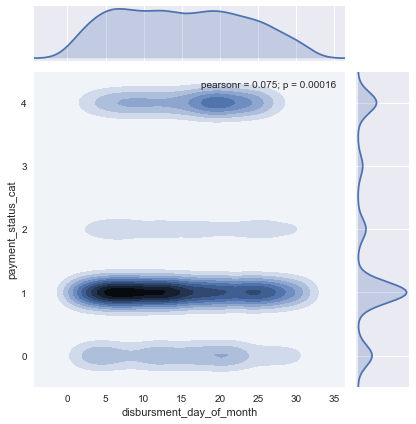

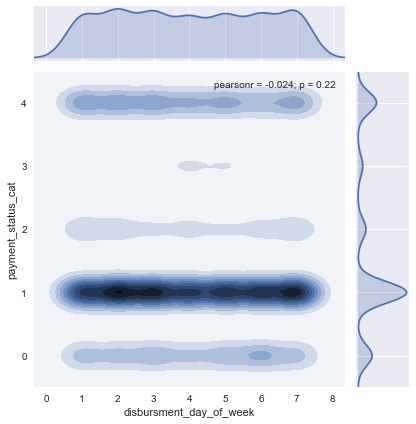

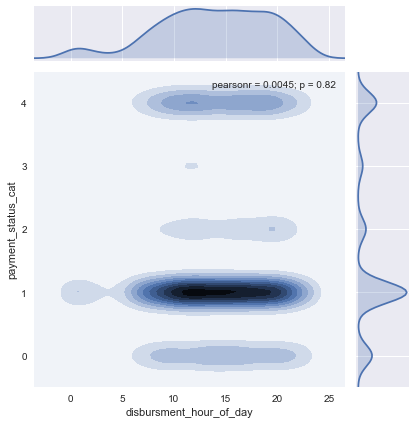

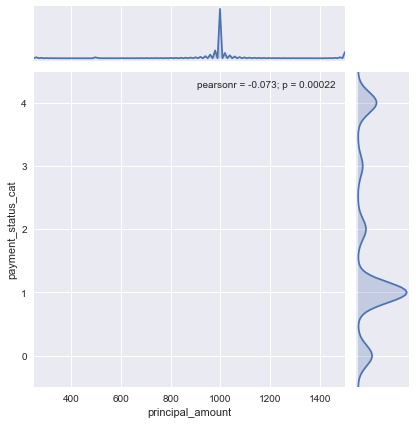

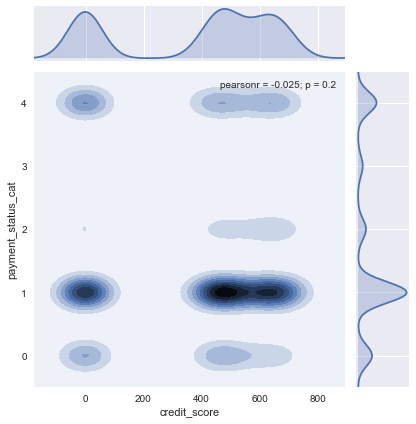

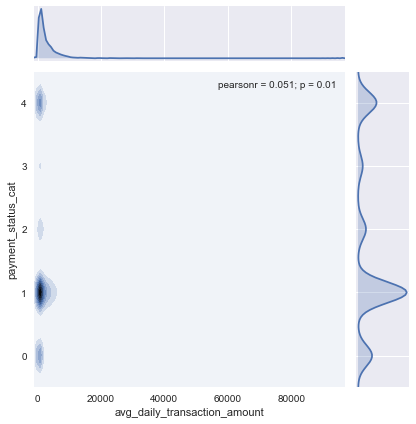

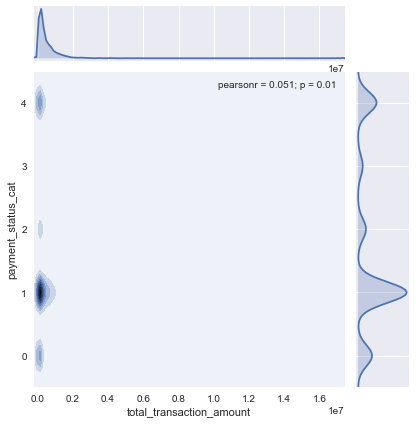

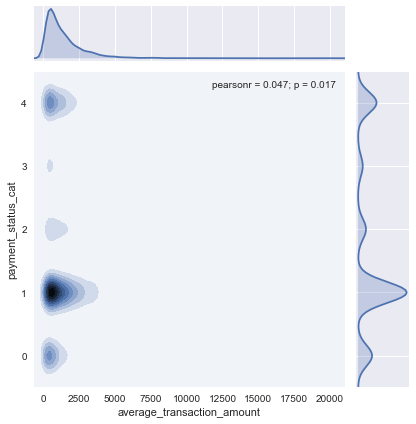

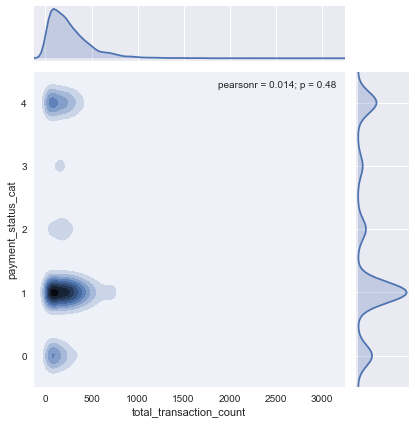

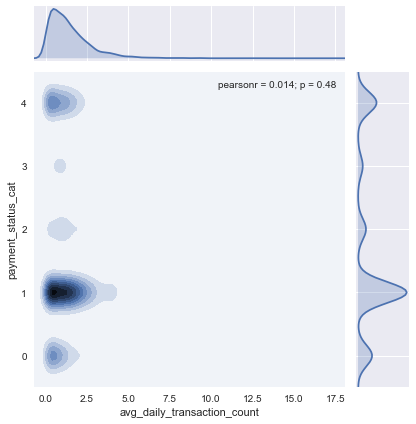

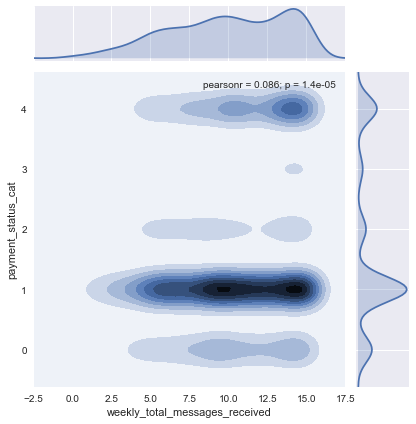

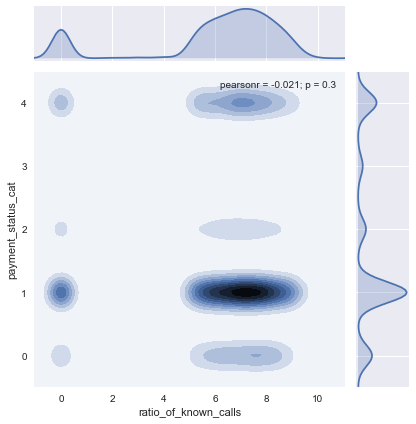

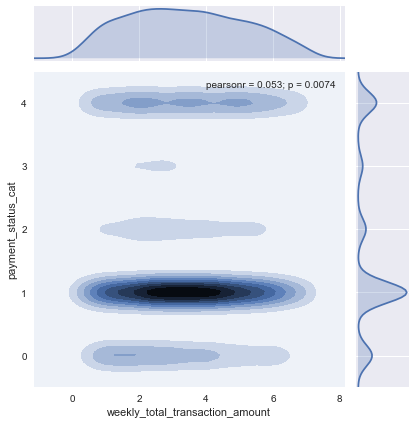

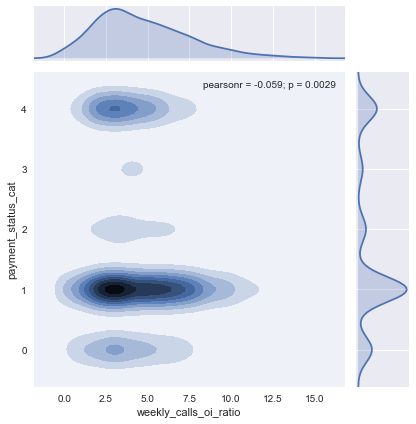

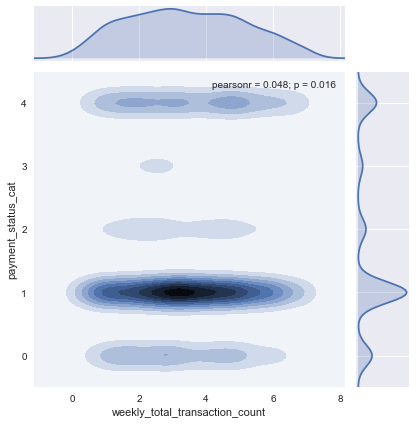

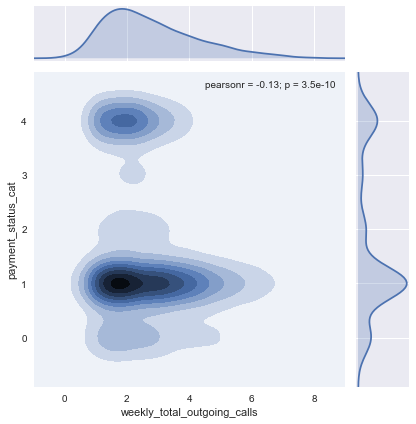

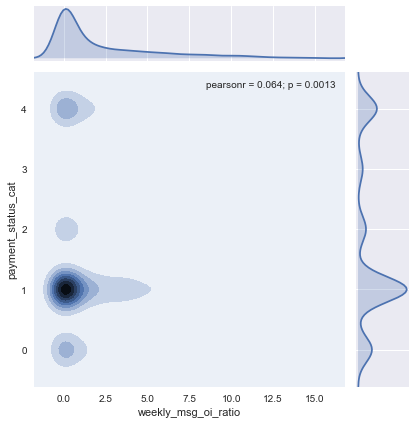

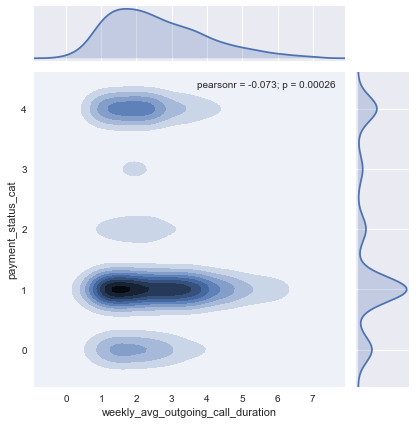

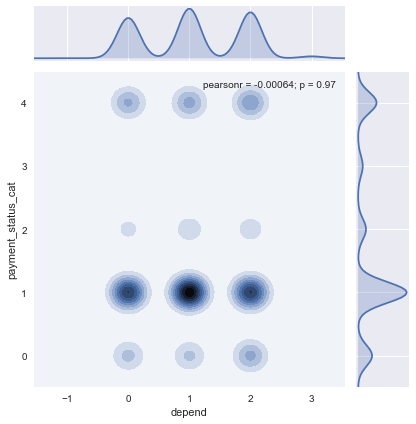

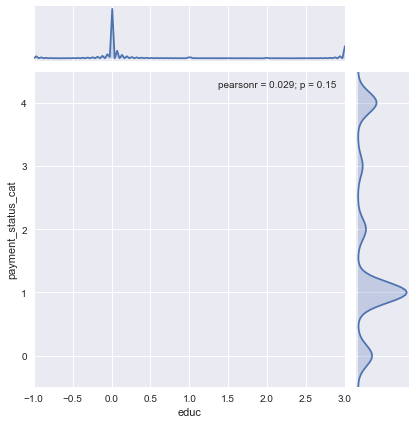

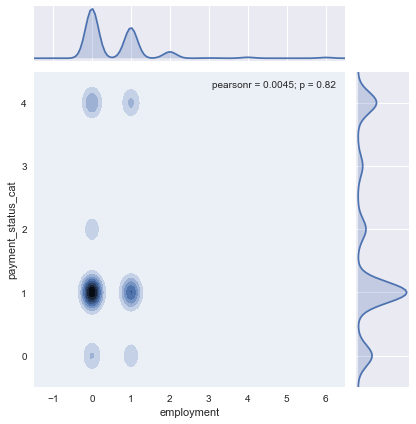

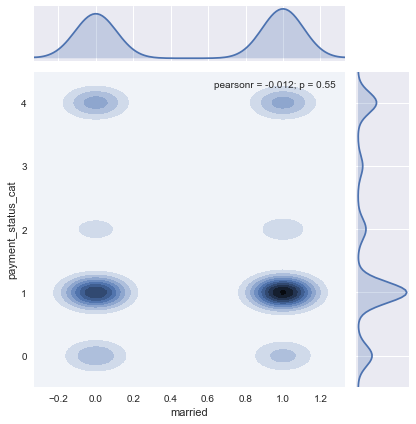

In [141]:
for feature in all_features:
    sns.jointplot(x=feature, y="payment_status_cat", data=data,kind="kde");

# Model

In [ ]:
#Define the input matrix and output/target 
X = data.filter(items = all_features)
y= data['payment_status_cat']


#Split X and Y into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=seed)

In [84]:
#Function that creates a new classifier
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        objective= 'multi:softmax',
        seed=seed,
        reg_lambda=reg_lambda
        
    )

#Function that returns the classifier and the resulting dataframe
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['merror','mlogloss' ]
    #metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]

    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    param['num_class'] = num_of_classes
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [85]:
clf, cvres = xgb_cross_validate(X_train, y_train)
#clf.score(X_test, y_test)
m = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 56.31%


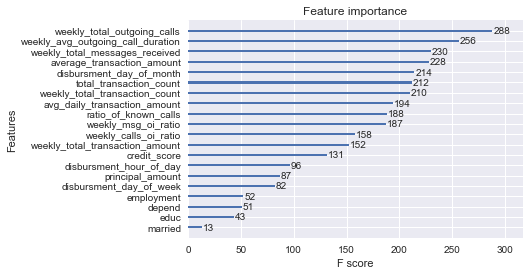

In [87]:
xgb.plot_importance(clf)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x10e537320>>
Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


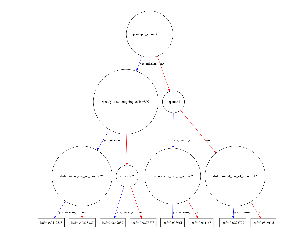

In [91]:
xgb.plot_tree(clf, num_trees=2)

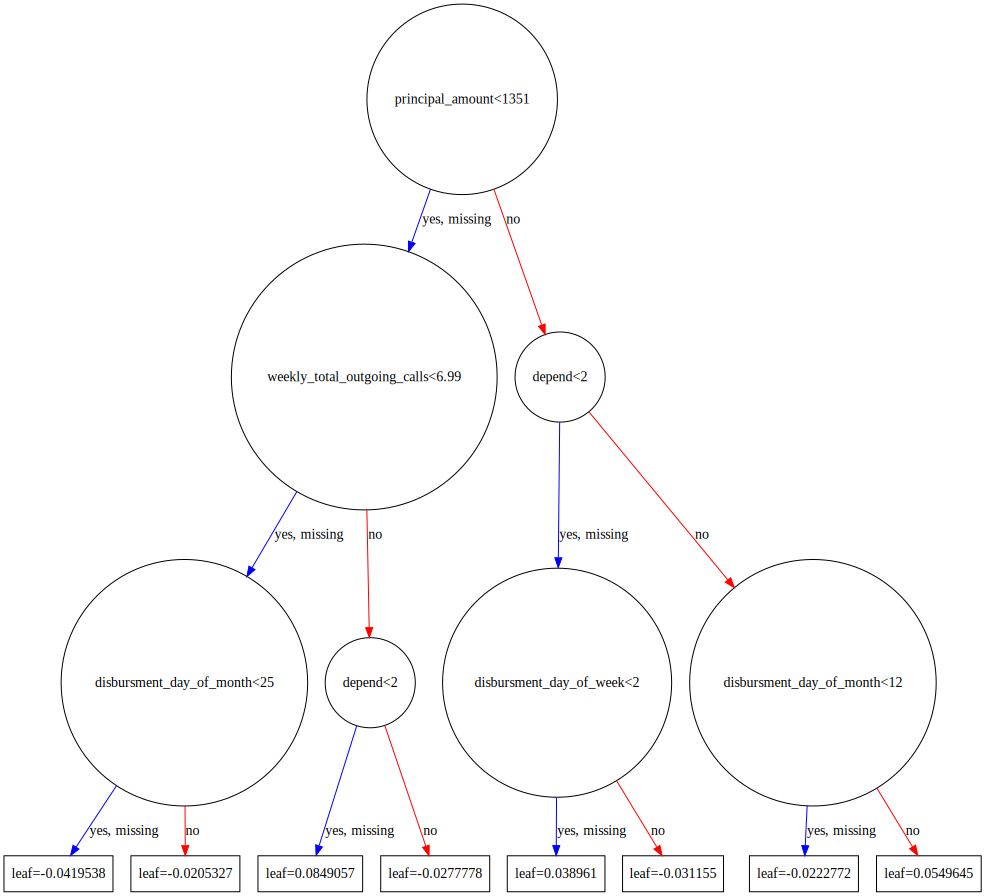

In [92]:
xgb.to_graphviz(clf, num_trees=2)

### Convert the problem to a binary problem(Default or not)


In [156]:

# Make a few changes to the classifier, the evaluation metrics,y, remove num_classes etc.

#Function that creates a new classifier
def fresh_clf2 () -> XGBClassifier:
    return XGBClassifier(
        objective= 'binary:logistic',
        seed=seed,
        reg_lambda=reg_lambda
        
    )

#Function that returns the classifier and the resulting dataframe
def xgb_cross_validate2 (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    # metrics = ['merror','mlogloss' ]
    # metrics = ['error@0.1', 'auc']
    metrics = [ 'auc' ]
    alg = fresh_clf2()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults


#Change y - output/target

#Create a new column 'default' that is true if a person is in default or their loan is unpaid
data['default'] = np.where((data['payment_status']=='IN DEFAULT') | (data['payment_status']=='UNPAID'),1,0)
y= data['default']



#Split X and Y into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=seed)

clf, cvres = xgb_cross_validate2(X_train, y_train)
#clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall  = recall_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F-Score: %.2f%%" % (fscore * 100.0))
print('\nConfusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 73.21%
Precision: 62.44%
Recall: 46.38%
F-Score: 53.22%

Confusion Matrix:
 [[487  77]
 [148 128]]


In [162]:
defaulters = data[data['default'] == 1 ]
non_defaulters = data[data['default'] == 0]
for feature in all_features:
    ttest = stats.ttest_ind(defaulters[feature],non_defaulters[feature], equal_var = False)
    print(feature, '-----',ttest[0], '-----',ttest[1])


disbursment_day_of_month ----- 2.33189048706 ----- 0.0198054785512
disbursment_day_of_week ----- -0.621598294357 ----- 0.534284081086
disbursment_hour_of_day ----- 0.18145426314 ----- 0.856031683493
principal_amount ----- -10.2438820245 ----- 3.76211984967e-24
credit_score ----- -5.39179764058 ----- 7.932313439e-08
avg_daily_transaction_amount ----- -2.93772338586 ----- 0.00335945279134
total_transaction_amount ----- -2.93772504296 ----- 0.00335943494776
average_transaction_amount ----- -3.4200746981 ----- 0.0006415382055
total_transaction_count ----- -3.58266622186 ----- 0.000349938956963
avg_daily_transaction_count ----- -3.58324515999 ----- 0.000349170163116
weekly_total_messages_received ----- nan ----- nan
ratio_of_known_calls ----- nan ----- nan
weekly_total_transaction_amount ----- -1.31222453738 ----- 0.189620263511
weekly_calls_oi_ratio ----- nan ----- nan
weekly_total_transaction_count ----- 0.146678619535 ----- 0.883402741597
weekly_total_outgoing_calls ----- nan ----- nan
w